### MDN References:

[useful pytorch reference](https://github.com/tonyduan/mixture-density-network)

[keras version](https://github.com/cpmpercussion/keras-mdn-layer)

[another keras version](https://github.com/omimo/Keras-MDN/blob/master/kmdn/mdn.py)


In [2]:
!pip install tensorflow-probability
!pip install graphviz

     |████████████████████████████████| 6.7 MB 25.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import MDN
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import pandas as pd
from ProcessTrueStateActionData import read_df_in_chunks

from true_state_viewer import TrueStateTreeGraphViz, display_tree_red_preds

import time
from IPython import display

### Load and preprocess the data 
(produce tf train+test datasets)

In [2]:
batch_size = 128
train_test_split = 0.999

LATENT_SIZE = 8 # (mdn output_dimension)
NUMBER_MIXTURES = 5

EPOCHS = 50

DATA_CAP = 3_000_000

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
def get_columns_for_training():
    true_states = ["pre","blue","red"]
    ts_columns = {}
    for true_state in true_states:
        ts_columns[true_state] = []
        for node in range(13):
            ts_columns[true_state].append(f"{node}_ts_{true_state}_known_status")
            ts_columns[true_state].append(f"{node}_ts_{true_state}_access_status")
    return ts_columns

In [4]:
cols_dict = get_columns_for_training()
pre_cols, blue_cols, red_cols = cols_dict["pre"], cols_dict["blue"], cols_dict["red"]
all_cols = pre_cols + blue_cols + red_cols

In [5]:
df=pd.read_parquet("csv_data/TrueStatesObsActsRwds_1221_4000_B_Line.parquet").iloc[:DATA_CAP]
df = df[all_cols].astype("category")

In [6]:
df.memory_usage(deep=True)

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index                      24000000
0_ts_pre_known_status       3000124
0_ts_pre_access_status      3000116
1_ts_pre_known_status       3000132
1_ts_pre_access_status      3000132
                             ...   
10_ts_red_access_status     3000132
11_ts_red_known_status      3000124
11_ts_red_access_status     3000132
12_ts_red_known_status      3000124
12_ts_red_access_status     3000132
Length: 79, dtype: int64

In [7]:
train_df=df.sample(frac=train_test_split,random_state=42)
train_pre_df = train_df[pre_cols]
train_blue_df = train_df[blue_cols]
train_red_df = train_df[red_cols]

test_df=df.drop(train_df.index)
test_pre_df = test_df[pre_cols]
test_blue_df = test_df[blue_cols]
test_red_df = test_df[red_cols]

train_size = train_df.shape[0]
test_size = test_df.shape[0]

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
print(train_size)

2997000


/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
train_dataset = (tf.data.Dataset.from_tensor_slices(((train_pre_df.values,train_blue_df.values),train_red_df.values)).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(((test_pre_df.values,test_blue_df.values),test_red_df.values)).shuffle(test_size).batch(1))

In [10]:
for row in train_dataset.take(1):
  print(row)

((<tf.Tensor: shape=(128, 26), dtype=int64, numpy=
array([[0, 0, 2, ..., 2, 1, 0],
       [1, 0, 1, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 1, 0],
       ...,
       [1, 0, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 1, 0]])>, <tf.Tensor: shape=(128, 26), dtype=int64, numpy=
array([[0, 0, 2, ..., 2, 1, 0],
       [1, 0, 1, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 1, 0],
       ...,
       [1, 0, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 1, 0]])>), <tf.Tensor: shape=(128, 26), dtype=int64, numpy=
array([[0, 0, 2, ..., 2, 1, 0],
       [1, 0, 1, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 1, 0],
       ...,
       [1, 0, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 1, 0]])>)


### Create an MDN based model with pretrained encoder/decoder layers

In [11]:
class RedTSPrediction(tf.keras.Model):

    def __init__(self, vae_path, latent_size, num_mixtures):
        super().__init__()
        self.ts_vae = tf.keras.models.load_model(vae_path)
        self.ts_vae.trainable = False
        self.encoder = self.ts_vae.encoder
        self.decoder = self.ts_vae.decoder

        self.ts_dense = tf.keras.layers.Dense(1024, activation=tf.nn.relu)
        self.cross_dense = tf.keras.layers.Dense(4096, activation=tf.nn.relu)
        
        self.fc_1 = tf.keras.layers.Dense(4096, activation=tf.nn.relu)

        self.mdn = MDN.MDN(output_dimension=latent_size, num_mixtures=num_mixtures)

    @tf.function(input_signature=[tf.TensorSpec(shape=[None,78], dtype=tf.float32)])
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        z = self.reparameterize(mean, logvar)
        return z
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None,LATENT_SIZE], dtype=tf.float32),tf.TensorSpec(shape=[None,LATENT_SIZE], dtype=tf.float32)])
    def reparameterize(self, mean, logvar):
        #     eps = tf.random.normal(shape=mean.shape)
        eps = tf.random.normal(shape=tf.shape(mean))

        return eps * tf.exp(logvar * .5) + mean
 
    @tf.function(input_signature=[tf.TensorSpec(shape=[None,LATENT_SIZE], dtype=tf.float32)])
    def decode(self, latent, apply_sigmoid=False):
        logits = self.decoder(latent)
        if apply_sigmoid:
          probs = tf.sigmoid(logits)
        return logits #self.decoder(latent_pred)

    @tf.function#(input_signature=[tf.TensorSpec(shape=[None,26], dtype=tf.uint8),tf.TensorSpec(shape=[None,26], dtype=tf.uint8)])
    def call(self, inputs):
        pre_ts = inputs[0]
        blue_ts = inputs[1]
        
        pre_ts_oh = tf.cast(tf.reshape(tf.one_hot(pre_ts,3),(-1,78)),tf.float32)
#         pre_ts_access = tf.reshape(tf.one_hot(pre_ts[:,13:],3),(-1,39))
        
        blue_ts_oh = tf.cast(tf.reshape(tf.one_hot(blue_ts,3),(-1,78)),tf.float32)
#         blue_ts_access = tf.reshape(tf.one_hot(blue_ts[:,13:],3),(-1,39))
        
#         print(pre_ts[:,:])
#         print(pre_ts_oh)
#         print(blue_ts)
#         blue_ts_kn = K.print_tensor(blue_ts[:,:13], message='blue known = ')
#         blue_ts_known = K.print_tensor(blue_ts_known[:,:13], message='blue known OH = ')
#         print(blue_ts_known.shape)

        pre_ts_encoded = self.encode(pre_ts_oh)
#         mean, logvar = self.ts_vae.encode(pre_ts_oh)
#         mean, logvar = tf.split(self.encoder(pre_ts_oh), num_or_size_splits=2, axis=1)
#         pre_ts_encoded = self.reparameterize(mean, logvar)
        pre_ts_encoded = self.ts_dense(pre_ts_encoded)
        
        blue_ts_encoded = self.encode(blue_ts_oh)
        blue_ts_encoded = self.ts_dense(blue_ts_encoded)

        combined = tf.keras.layers.concatenate([pre_ts_encoded, blue_ts_encoded])

        combined_hidden = self.cross_dense(combined)
        
        fc = self.fc_1(combined_hidden)

        mdn_out = self.mdn(fc)

        return mdn_out
        


In [12]:
@tf.function
def forward_pass(model, x, y):
    out = model(x)
    
    y_oh = tf.reshape(tf.one_hot(y,3),(-1,78))
    y_encoded = model.encode(y_oh)
    
    return out, y_encoded

@tf.function
def decode_z(model, x):
    x_oh = model.ts_vae.get_oh_output(model.decode(tf.cast(x,tf.float32)))
#     y_oh = model.ts_vae.get_oh_output(model.decode(tf.cast(y,tf.float32)))
    
    return x_oh
    

@tf.function
def compute_loss(model, x, y, loss_func):
    out, y_encoded = forward_pass(model, x, y)
    
    loss = loss_func(y_encoded, out)
    
    return loss
    

@tf.function
def train_step(model, x, y, optimizer, loss_func):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
#     y_encoded = model.encode(y)
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, y, loss_func)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

### Training loop

In [16]:
red_ts_predictor = RedTSPrediction('models/trueStateVAE_7_L8', latent_size=LATENT_SIZE, num_mixtures=NUMBER_MIXTURES)

In [16]:
for row in test_dataset.take(1):
#   print(row)
  out = red_ts_predictor(row[0])
  print(out)

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tf.Tensor(
[[-0.06636233 -0.06196863 -0.08817287  0.12303808 -0.03705209 -0.01493803
  -0.00503008  0.10226319 -0.06025334  0.04935768  0.13545874  0.1443982
  -0.00673253  0.05317534 -0.00584378  0.01755999  0.02257365  0.00734199
   0.04717761 -0.07985166  0.09626295  0.09198944 -0.02515574  0.04726454
  -0.06299229  0.00766238 -0.02950492  0.00164744  0.0475982   0.07596546
  -0.10514942 -0.02257304  0.04072241  0.04947118  0.05239626 -0.0295922
   0.05846119 -0.01432874 -0.09409164 -0.07094117  0.89395356  0.9839407
   1.0574708   1.0400155   1.0313317   1.0254508   0.9718906   1.0144798
   0.9024779   0.89091784  0.9417944   0.8664818   0.92457443  0.96488357
   1.1224772   0.99278593  0.95341545  1.00197     1.0942274   1.0427505
   0.9794328   0.9148203   0.95995295  0.80498016  0.9711414   1.059449
   0.98219275  1.094553    1.0087867   1.0833644   0.90040547  0.96063066
   1.1737413   1.07974     0.9161177   1.1924531   0.9173192   1.1098535
   0.887524    1.1287848   0.038761

In [17]:
# red_ts_predictor.compile(loss=get_mixture_loss_func(LATENT_SIZE,NUMBER_MIXTURES,red_ts_predictor.encode), optimizer=tf.keras.optimizers.Adam(),metrics=['mean_squared_error'])
# red_ts_predictor.build(((1,78),(1,78)))
red_ts_predictor.summary()


Model: "red_ts_prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 true_state_vae_4 (TrueState  multiple                 121736094 
 VAE)                                                            
                                                                 
 sequential_8 (Sequential)   (None, 16)                60892016  
                                                                 
 sequential_9 (Sequential)   (None, 78)                60844078  
                                                                 
 dense (Dense)               multiple                  9216      
                                                                 
 dense_1 (Dense)             multiple                  8392704   
                                                                 
 dense_2 (Dense)             multiple                  16781312  
                                                 

In [13]:
loss_func = MDN.get_mixture_loss_func(LATENT_SIZE,NUMBER_MIXTURES)
optimizer = tf.keras.optimizers.Adam(1e-4)

In [17]:
# train_dataset=test_dataset.take(10)

# EPOCHS = 500
for epoch in range(1, EPOCHS + 1):
    count = 0
    start_time = time.time()
    for train_x, train_y in train_dataset:
        if (count %1000) == 0:
            print(f"{count}={count*batch_size} samples")
        train_step(red_ts_predictor, train_x, train_y, optimizer, loss_func)
        count += 1
    end_time = time.time()

    
    total_matches = 0
    total = 0
    nodes = 0
    sum_diffs_sqrd = 0
    state_pred_pairs = []
    state_pred_pair_tree_vis = []
    loss = tf.keras.metrics.Mean()
    for test_x, test_y in test_dataset.take(1000):#.take(10):#test_dataset:
        total += 1
        if (total %100) == 0:
            print(f"{total}={total*1} samples")
        out, y_encoded = forward_pass(red_ts_predictor, test_x, test_y)
        loss_val = loss_func(y_encoded, out)
        loss(loss_val)
        
#         sampled_out = MDN.sample_from_output(out[0].numpy(), output_dim=LATENT_SIZE, num_mixes=NUMBER_MIXTURES)
#         pred_oh, y_oh = decode_zs(red_ts_predictor, sampled_out, y_encoded)
        
        
#         state_pred_pairs.append([y_oh, pred_oh])
# #         state_pred_pair_tree_vis.append([TrueStateTreeGraphViz(y_oh), TrueStateTreeGraphViz(pred_oh)])
# #         loss(compute_loss(red_ts_predictor, test_x, test_y, loss_func))
#         diffs = np.rint(y_oh.numpy()) - np.rint(pred_oh.numpy())
#     #     diffs = get_state_diff(true_state_model,test_x)
#         nodes += len(diffs.flatten())
#         diffs_sqrd = np.sum(diffs*diffs)
#         sum_diffs_sqrd += diffs_sqrd
#         if not diffs_sqrd >0:
#     #       print(diffs)
#     #     else:
#           total_matches += 1
#     #       print("Match")
    #       print(diffs)

    loss = loss.result()
    display.clear_output(wait=False)
#     print(f"accuracy = {total_matches}/{total} = {total_matches/total}, \nmean of squared diffs = {sum_diffs_sqrd}/{nodes}={sum_diffs_sqrd/nodes}\npercentage wrong = ({sum_diffs_sqrd}/{2})/({nodes}/{3})={(sum_diffs_sqrd/2)/(nodes/3)}")
    print('Epoch: {}, Test set loss: {}, time elapse for current epoch: {}'
        .format(epoch, loss, end_time - start_time))
#     display_tree_pairs(state_pred_pair_tree_vis)

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0=0 samples
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
1000=128000 samples
2000=256000 samples


KeyboardInterrupt: 

In [20]:
# pre_ts_encoded = red_ts_predictor.ts_vae.encode(np.zeros((1,78),dtype=np.float32))
# red_ts_predictor.ts_dense(pre_ts_encoded)

red_ts_predictor((np.zeros((1,26),dtype=np.uint8),np.zeros((1,26),dtype=np.uint8)))

red_ts_predictor.save('models/RedTSPredictionMDN_2',overwrite=True)

### Test and evaluate

In [18]:
m2 = tf.keras.models.load_model(
    'models/RedTSPredictionMDN_2',
)

In [22]:
total_matches = 0
total = 0
nodes = 0
sum_diffs_sqrd = 0
state_pred_pairs = []
state_pred_pair_tree_vis = []
state_pred_samples_correct = []

red_change_test_indices = []
no_change_indices = []

loss = tf.keras.metrics.Mean()

num_eval_samples = 10

for i, (test_x, test_y) in enumerate(test_dataset.take(3000)):#.take(10):#test_dataset:
    pre_ts = tf.reshape(tf.one_hot(test_x[0],3),(-1,2,3))
    blue_ts = tf.reshape(tf.one_hot(test_x[1],3),(-1,2,3))
    
    out, y_encoded = forward_pass(m2, test_x, test_y)
#     y_oh = decode_z(m2, y_encoded)
    
    y_oh = tf.one_hot(tf.reshape(test_y,(-1,2)),depth=3)
    
#     if not ONLY_MEASURE_CHANGES or np.any(blue_ts != y_oh):

    if np.any(blue_ts != y_oh):
        red_change_test_indices.append(i)
    else:
        no_change_indices.append(i)
        
    loss_val = loss_func(y_encoded, out)
    loss(loss_val)

    y_tree_vis = TrueStateTreeGraphViz(y_oh)

    predictions = []
    pred_tree_vis = []
    pred_corrects = []
    for i in range(num_eval_samples):
        total += 1
        sampled_out = MDN.sample_from_output(out[0].numpy(), output_dim=LATENT_SIZE, num_mixes=NUMBER_MIXTURES)
        pred_oh = decode_z(m2, sampled_out)

        predictions.append(pred_oh)
        pred_tree_vis.append(TrueStateTreeGraphViz(pred_oh))

        diffs = np.rint(y_oh.numpy()) - np.rint(pred_oh.numpy())
        diffs_sqrd = np.sum(diffs*diffs)
        sum_diffs_sqrd += diffs_sqrd

        nodes += len(diffs.flatten())
        pred_correct = not diffs_sqrd >0
        if pred_correct:
            total_matches += 1
        pred_corrects.append(pred_correct)



    state_pred_pairs.append([y_oh, predictions])

    state_pred_pair_tree_vis.append([TrueStateTreeGraphViz(pre_ts),
                                     TrueStateTreeGraphViz(blue_ts),
                                     y_tree_vis,
                                     pred_tree_vis])

    state_pred_samples_correct.append(pred_corrects)

state_pred_samples_correct = np.array(state_pred_samples_correct)

#         state_pred_pairs.append([y_oh, pred_oh])
#     state_pred_pair_tree_vis.append([TrueStateTreeGraphViz(y_oh), TrueStateTreeGraphViz(pred_oh)])
#         loss(compute_loss(m2, test_x, test_y, loss_func))
#     diffs = np.rint(y_oh.numpy()) - np.rint(pred_oh.numpy())
#     diffs = get_state_diff(true_state_model,test_x)
#     nodes += len(diffs.flatten())
#     diffs_sqrd = np.sum(diffs*diffs)
#     sum_diffs_sqrd += diffs_sqrd
#     if not diffs_sqrd >0:
# #       print(diffs)
# #     else:
#       total_matches += 1
#       print("Match")
#       print(diffs)

loss = loss.result()
display.clear_output(wait=False)
print(f"accuracy = {total_matches}/{total} = {total_matches/total}, \nmean of squared diffs = {sum_diffs_sqrd}/{nodes}={sum_diffs_sqrd/nodes}\npercentage wrong = ({sum_diffs_sqrd}/{2})/({nodes}/{3})={(sum_diffs_sqrd/2)/(nodes/3)}")
# print('Epoch: {}, Test set loss: {}, time elapse for current epoch: {}'
#     .format(epoch, loss, end_time - start_time))


accuracy = 19694/30000 = 0.6564666666666666, 
mean of squared diffs = 25554.0/2340000=0.010920512820512821
percentage wrong = (25554.0/2)/(2340000/3)=0.01638076923076923


/usr/local/lib/python3.8/dist-packages/ipykernel/pylab/backend_inline.py:14: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display
/usr/local/lib/python3.8/dist-packages/ipykernel/pylab/backend_inline.py:160: DeprecationWarning: `configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`
  configure_inline_support(ip, backend)


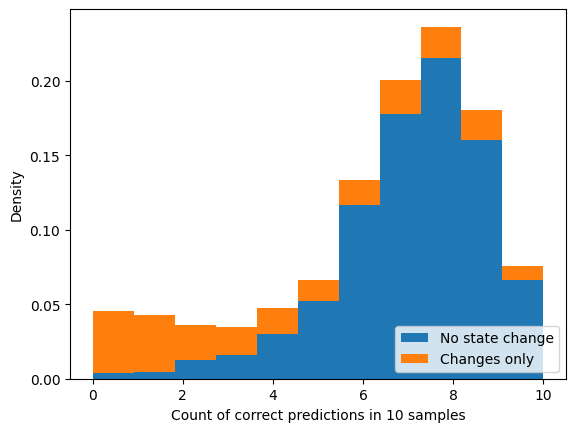

In [23]:
import matplotlib.pyplot as plt

correct_pred_counts = np.sum(state_pred_samples_correct[no_change_indices],axis=1)

correct_pred_counts_change_only = np.sum(state_pred_samples_correct[red_change_test_indices], axis=1)

# print(f"Correct prediction frequencies: {correct_pred_counts}")

plt.hist([correct_pred_counts,correct_pred_counts_change_only],num_eval_samples+1,density=True, stacked=True, label=["No state change", "Changes only"])
# plt.hist(correct_pred_counts_change_only,num_eval_samples+1,density=True)
plt.legend(loc="lower right")
plt.xlabel('Count of correct predictions in 10 samples')
plt.ylabel('Density')
plt.show()

In [24]:
from importlib import reload
import true_state_viewer
reload(true_state_viewer)
from true_state_viewer import display_tree_red_preds

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
display_tree_red_preds(state_pred_pair_tree_vis)

3000


/usr/local/lib/python3.8/dist-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(IntSlider).__init__(name='Index').
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
/usr/local/lib/python3.8/dist-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(HBox).__init__(overflow_x='auto', overflow='scroll').
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
